# Problem:
Students are free to choose some different images for experimenting with the following requirements:
- Load an image.
- Do low-pass filter.
- Do high-pass filter.
- Write report.

# Load image

In [65]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt

In [66]:
image = cv2.imread('input/cameraman.tif',cv2.IMREAD_GRAYSCALE)

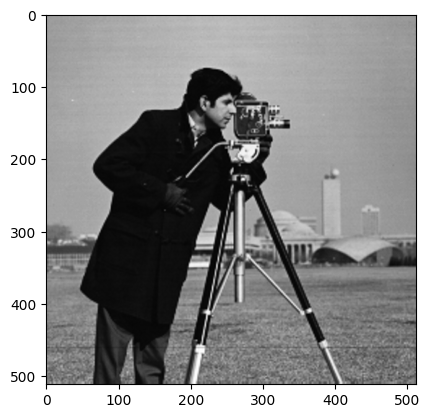

In [67]:
# cv2.imshow(winname='test',mat=image)
plt.imshow(image, cmap='gray')
plt.show()

In [68]:
image.shape

(512, 512)

# Theories

## Cross-correlation

Let $F$ be the image, $H$ be the kernel (of size $2k+1$ x $2k+1$), and $G$ be the output image: $$G[i,j] = \sum_{u=-k}^{k} \sum_{v=-k}^{k} H[u,v]F[i+u,j+v]$$ This is called a **cross--correlation** operation: $$G=H \otimes F$$

## Convolution

A **convolution** operation is a cross-correlation where the filter is flipped both horizontally and vertically before being applied to the image: $$G[i,j] = \sum_{u=-k}^{k} \sum_{v=-k}^{k} H[u,v]F[i-u][j-v]$$. It is written: $$G = H \star F$$

## Fourier Transform

### Brief Description

The Fourier Transform is an important image processing tool which is used to decompose an image into its sine and cosine components. The output of the transformation represents the image in the *Fourier* or _frequency domain_, while the input image is the _spatial domain_ equivalent. In the Fourier domain image, each point represents a particular _frequency_ contained in the spatial domain image.

**We are only concerned with digital images, we will restrict this discussion to the Discrete Fourier Transform (DFT)**

The DFT is the sampled Fourier Transform and therefore does not contain all frequencies forming an image, but only a set of samples which is large enough to fully describe the spatial domain image. The number of frequencies corresponds to the number of pixels in the spatial domain image, i.e. the image in the spatial and Fourier domain are of the same size.

For a square image of size $N$ x $N$, the two-dimensional DFT is given by: $$f(u,v) = \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} f(i,j) e^{-\mathbf{i}2\pi(\frac{ui}{N} + \frac{vj}{N})}$$ where $f(a,b)$ is the image in the spatial domain and the exponential term is the basis function corresponding to each point $F(u,v)$ in the Fourier space. The equation can be interpreted as: __the value of each point $F(u,v)$ is obtained by multiplying the spatial image with the corresponding base function and summing the result__.

In a similar way, the Fourier image can be re-transformed to the spatial domain. The inverse Fourier transform is given by: $$f(a,b) = \frac{1}{N^2} \sum_{u=0}^{N-1} \sum_{v=0}^{N-1} F(u,v) e^{\mathbf{i}2\pi(\frac{ua}{N} + \frac{vb}{N})}$$ with $\frac{1}{N^2}$ is the normalization term in the inverse transformation. This normalization is sometimes applied to the foward transform instead of the inverse transform, but it should not be used for both.

To obtain the result for the above equations, a __double sum__ has to be calculated for __each image point__. However, because the Fourier Transform is _separable_, it can be written as $$F(u,v) = \frac{1}{N} \sum_{b=0}^{N-1} P(u,b) e^{-\mathbf{i}2\pi \frac{vb}{N}}$$ where $$P(u,b) = \frac{1}{N} \sum_{a=0}^{N-1} f(a,b) e^{-\mathbf{i}2\pi \frac{ua}{N}}$$

The Fourier TRansform produces a complex number valued output image which can be displayed with two images, either with the _real_ and _imaginary_ or the _magnitude_ and _phase_. In __image processing__, ofthen only the magnitude of the Fourier Transform is displayed, as it _contains most of the information of the geometric structure of the spatial domain image_. However, if we want to __re-transform__ the Fourier image into the correct spatial domain after some processing in the frequency domain, we must make sure to __preserver both magnitude and phase of the Fourier image__


## Frequency Filter

### Brief Description

Frequency filters process an image in the frequency domain. The image is Fourier transformed, multiplied with the filter function and then re-transformed into the spatial domain. __Attenuating high frequencies results in a smoother image in the spatial domain, attenuating low frequencies enhances the edges.__

Frequency filtering is based on the Fourier Transform. The operator usually takes an image and a filter function in the Fourier domain__. This image is then multiplied with the filter function in a __pixel-by-pixel fashion__: $$G(u,v) = F(u,v)*H(u,v)$$ with $H(u,v)$ is the filter function, $F(u,v)$ is the input image in the Fourier domain. To resulting image in the __spatial domain__, $G(u,v)$ has t be re-transformed using the inverse Fourier Transform.

Since the __multiplication in the Fourier space__ is __identical__ to __convolution in the spatial domain__, all frequency filters can in theory be implemented as a spatial filter. However, in practice, the Fourier domain filter function can only be approximated by the filtering kernel in spatial domain.

## Ideal Filter

The most simple low-pass filter is the __ideal low-passs filter__

The ideal low-pass filter suppresses all frequencies higher than the _cut-off frequency_ $D_0$ and leaves smaller frequencies unchaged: $$ H(u,v) = \begin{cases}
1 &if D(u,v) \leq D_0 \\ 
0 &if D(u,v) \gt D_0
\end{cases}$$ with $D(u,v)$ is just a distance from point $(u,v)$ to original point of the frequency plane. $$D(u,v)= \sqrt{u^2 + v^2}$$

Similarly, the __ideal high-pass filter (IHPF)__ is defined as: $$H(u,v) = \begin{cases}
0 &if D(u,v) \leq D_0 \\
1 &if D(u,v) \gt D_0
\end{cases}$$

After the kernel is constructed, we applied to the image in frequency domain, $F$, to get the filtered image $G$. $$G(u,v) = F(u,v) \star H(u,v)$$ _with element-wise multiplication_.

Finally, the filtered image in spatial domain is calculated as follows: $$g(x,y) = G^{-1}(u,v)$$ with $G^{-1}$ is the inverse FFT

## Butterworth Filter

A two-dimensional ___Butterworth low-pass filter (BLPF)___ of order $n$ is a low-pass filter whose kernel is defined as: $$H(u,v) = \frac{1}{1 +  [D(u,v) / D_0]^{2n}}$$

Similarly, the ___Butterworth high-pass filter (IHPF)___ is defined as: $$H(u,v) = \frac{1}{1+[D_0 / D(u,v)]^{2n}}$$

# Implementation

In [69]:
def constructDuv(N):
    """Constructs the frequency matrix, D(u,v), of size NxN"""
    u = np.arange(N)
    v = np.arange(N)
    
    idx = np.where(u>N/2)[0]
    # print(idx)
    u[idx] = u[idx] - N
    idy = np.where(v>N/2)[0]
    # print(idy)
    v[idy] = v[idy] - N
    
    [V,U] = np.meshgrid(v,u)
    # print(V)
    # print(U)
    D = np.sqrt(U**2 + V**2)
    
    return D

[[0.         1.         2.         ... 3.         2.         1.        ]
 [1.         1.41421356 2.23606798 ... 3.16227766 2.23606798 1.41421356]
 [2.         2.23606798 2.82842712 ... 3.60555128 2.82842712 2.23606798]
 ...
 [3.         3.16227766 3.60555128 ... 4.24264069 3.60555128 3.16227766]
 [2.         2.23606798 2.82842712 ... 3.60555128 2.82842712 2.23606798]
 [1.         1.41421356 2.23606798 ... 3.16227766 2.23606798 1.41421356]]


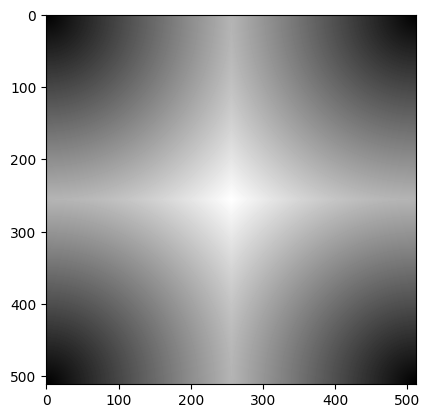

In [70]:
# illustration result
D = constructDuv(512)
print(D)
# print(D[4,3])
plt.imshow(D,cmap='gray')
plt.show()

In [81]:
def computeIdealFiltering(D, Do, mode=0):
    """Computes Ideal Filtering based on the cut off frequency (Do).
    If mode=0, it compute Lowpass Filtering otherwise Highpass filtering
    """
    H = np.zeros_like(D)
    if mode==0:
        H = (D<=Do).astype(int)
    else:
        H = (D>Do).astype(int)
    return H

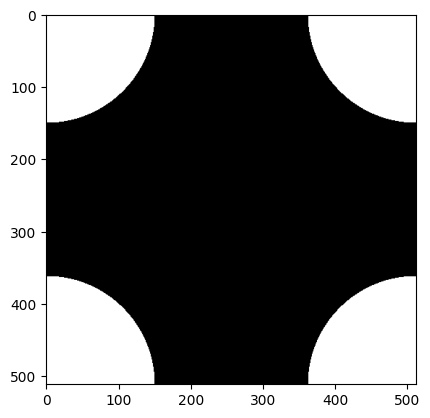

In [72]:
plt.imshow(computeIdealFiltering(D, 150, 0),cmap='gray')
plt.show()

In [73]:
import time

def computeIdealFilters(image, F, D, Dos):
    """
    Computes Ideal Filtering for different cut-off frequencies.
    """
    # low-pass filtered images
    LPgs = []
    
    # High-pass filtered images
    HPgs = []
    
    # Running Time
    IRunningTime = []
    
    for Do in Dos:
        starttime = time.time()
        
        # Computes Lowpass Filtering (ILPF)
        H = computeIdealFiltering(D, Do, 0)
        
        IRunningTime.append(time.time() - starttime)
        
        # Compute the filtered images (result in space domain)
        LPgs.append(computeFilteredImage(H, F))
        
        # Computes Highpass Filtering (IHPF)
        H = computeIdealFiltering(D, Do, 1)
        
        # Compute the filtered images (result in space domain)
        HPgs.append(computeFilteredImage(H, F))
        
    return LPgs, HPgs, IRunningTime

In [74]:
def computeButterworthFiltering(D:np.ndarray, Do, n, mode = 0):
    """Computes Ideal Filtering based on the cut-off frequency and order n.
    """
    H = np.zeros_like(D)
    D = D.astype(float)
    
    if mode == 0:
        H = 1 / (1 + (D/Do)**(2*n))
    else:
        H = 1 / (1 + (Do/D)**(2*n))
    return H

In [75]:
def computeButterFilters(image, F, D, Dos, ns):
    """Compute Butterworth Filtering for different cut-off frequencies"""
    
    # Low-pass filtered images
    LPgs = []
    
    # High-pass filtered images
    HPgs = []
    
    # Running time
    BRunningTime = []
    
    for index,Do in enumerate(Dos):
        startTime = time.time()
        H = computeButterworthFiltering(D, Do, ns[index], 0)
        BRunningTime.append(time.time() - startTime)
        LPgs.append(computeFilteredImage(H, F))
        
        H = computeButterworthFiltering(D, Do, ns[index], 1)
        HPgs.append(computeFilteredImage(H,F))
        
    return LPgs, HPgs, BRunningTime

In [76]:
def computeFilteredImage(H, F):
    """Computes a filtered image based on the given fourier transformed image(F) and filter(H)"""
    G = H * F  #! element-wise
    g = np.real(np.fft.ifft2(G)).astype(int)
    
    return g

In [77]:
def visualizeFilteringResults(image, F, LPgs, HPgs, Dos, filterType = 'Ideal', ns=None):
    """Visualizes the filtered images using different cut-off frequencies."""
    
    fig, axarr = plt.subplots(2,5, figsize=(10,5))
    
    axarr[0,0].imshow(image, cmap=plt.get_cmap('gray'))
    axarr[0,0].set_title('Original Image')
    axarr[0,0].axes.get_xaxis().set_visible(False)
    axarr[0,0].axes.get_yaxis().set_visible(False)
    
    axarr[1, 0].imshow(image, cmap=plt.get_cmap('gray'))
    axarr[1, 0].set_title("Original Image")
    axarr[1, 0].axes.get_xaxis().set_visible(False)
    axarr[1, 0].axes.get_yaxis().set_visible(False)
    
    # Display the results
    for index, g in enumerate(LPgs):
        
        if filterType=='Ideal':
            lp = 'ILPF (Do=%i)'%Dos[index]
            hp = 'IHPF (Do=%i)'%Dos[index]
        else:
            lp = 'BLPF (Do=%i, n=%i)'%(Dos[index],ns[index])
            hp = 'BHPF (Do=%i, n=%i)'%(Dos[index],ns[index])

        axarr[0,index+1].imshow(LPgs[index], cmap=plt.get_cmap('gray'))
        axarr[0,index+1].set_title(lp)
        axarr[0,index+1].axes.get_xaxis().set_visible(False)
        axarr[0,index+1].axes.get_yaxis().set_visible(False)
        
        axarr[1,index+1].imshow(HPgs[index], cmap=plt.get_cmap('gray'))
        axarr[1,index+1].set_title(hp)
        axarr[1,index+1].axes.get_xaxis().set_visible(False)
        axarr[1,index+1].axes.get_yaxis().set_visible(False)
        
    plt.show()
            

## Applying the Filters

In [78]:
F = np.fft.fft2(image)
N = image.shape[0]
D = constructDuv(N)

In [82]:
Dos = np.array([10,20,40,100])

# Ideal Filtering
ILPgs, IHPgs, IRunningTime = computeIdealFilters(image, F, D, Dos)

# Butterworth Filtering
ns = np.ones(Dos.shape[0])*2
BLPgs, BHPgs, BRunningTime = computeButterFilters(image, F, D, Dos, ns)

C:\Users\GAMING\AppData\Local\Temp\ipykernel_22880\452571565.py:10: RuntimeWarning: divide by zero encountered in divide
  H = 1 / (1 + (Do/D)**(2*n))


Ideal Filtering


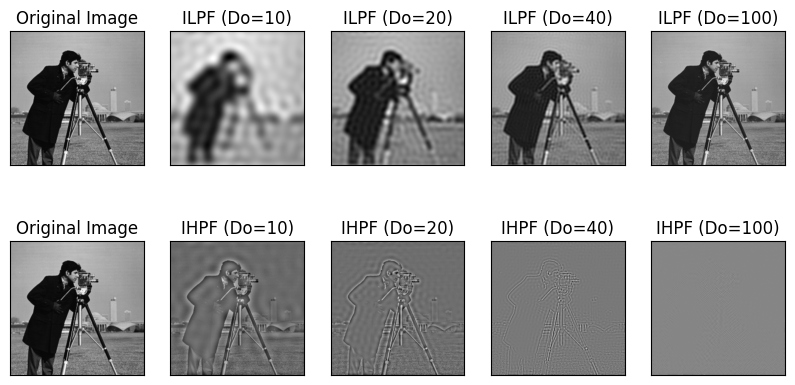

In [83]:
print('Ideal Filtering')
visualizeFilteringResults(image, F, ILPgs, IHPgs, Dos, 'Ideal')

Butterworth Filtering


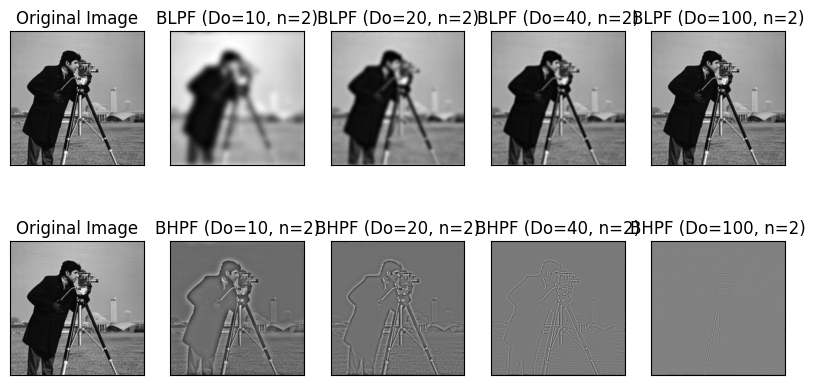

In [85]:
print('Butterworth Filtering')
visualizeFilteringResults(image, F, BLPgs, BHPgs, Dos, 'Butterworth', ns.astype(int))